# Design and Deploy.

NameError: name 'data' is not defined

In [2]:
# PURPOSE: Make PDFs of any kinematic distribution (e.g., delta_pT/pT), 
#          in specified eta, pT, and q*d0 bins.
#          Can perform Gaussian fits of distributions and put the fit stats
#          on the plots. 
# NOTES:   One PDF is made per eta bin. 
#          Each page of the PDF represents a different pT bin.
#          Many plots are shown on a single page; these are different q*d0 bins.
#          In total, N q*d0BS distributions are made per page.
#          N is determined automatically based on len(qd0_ls).
#          User should check User parameters.
# SYNTAX:  python <script>.py
# AUTHOR:  Jake Rosenzweig
# UPDATED: 2020-05-27

import os
# import sys
# import math
# import time

# import numpy as np
# import matplotlib.pyplot as plt

# # Local imports.
# from vaex_Utils.vaex_dataframes import (vdf_MC_2017_DY, vdf_MC_2017_Jpsi, vdf_MC_2017_DY,
#                                         prepare_vaex_df, vaex_apply_masks)
# from d0_Studies.kinematic_bins import (equal_entry_bin_edges_eta_mod1)
# from d0_Utils.d0_dicts import label_LaTeX_dict
# from d0_Utils.d0_fns import make_binning_array, print_header_message

# from PyUtils.Utils_Physics import perc_diff
from PyUtils.Utils_Files import check_overwrite#, makeDirs, make_str_title_friendly, 
# from PyUtils.Utils_Plotting import hist_y_label, make_1D_dist, ncolsrows_from_nplots
# from PyUtils.Utils_StatsAndFits import iterative_fit_gaus

from Samples.sample_info import MC_2017_Jpsi_hdf5

# from matplotlib.backends.backend_pdf import PdfPages

#---------------------------#
#----- User Parameters -----#
#---------------------------#
# Samples:
outdir_plots = "/ufrc/avery/rosedj1/HiggsMassMeasurement/d0_Studies/Plots/hists_m2mu_Jpsi/"
filename_base = "20200527_Test01_MC2017Jpsi_pTcorrection"
overwrite = False
verbose = True

fullpath_plots = os.path.join(outdir_plots, filename_base)
check_overwrite(fullpath_plots, overwrite=overwrite)    

# MC_2017_Jpsi_hdf5.vdf_prepped

[INFO] Successfully retrieved vdf_concat!
[INFO] vdf_concat has the following columns:
['massZ', 'massZErr', 'weight', 'GENmass2l', 'nFSRPhotons', 'pT', 'eta', 'phi', 'm', 'd0BS', 'd0PV', 'Id', 'pterr', 'genLep_pt', 'genLep_eta', 'genLep_phi', 'delta_eta', 'delta_phi', 'delta_R', 'delta_pT', 'delta_pToverGenpT', 'delta_pToverRecpT', 'delta_pToverGenpTsqred', 'delta_pToverRecpTsqred', 'qd0BS', 'qd0PV', 'index']



In [3]:
# import ROOT

mu1_pT_arr = MC_2017_Jpsi_hdf5.vdf_original.pT1
mu1_eta_arr = MC_2017_Jpsi_hdf5.vdf_original.eta1
mu1_phi_arr = MC_2017_Jpsi_hdf5.vdf_original.phi1
mu1_mass_arr = MC_2017_Jpsi_hdf5.vdf_original.m1

In [6]:
assert mu1_pT_arr.count() == mu1_eta_arr.count() == mu1_phi_arr.count() == mu1_mass_arr.count()

In [ ]:
skip_bad_fit = True
do_unbinned_fit = True  # If false, will default to binned fit.
iter_gaus = (True, 5)

# Binning.
# eta_ls = equal_entry_bin_edges_eta_mod1_wholenum
# pT_ls = bin_edges_pT_sevenfifths_to1000GeV_wholenum
eta_ls = [1.4, 1.6]
pT_ls = [30.0, 40.0, 50.0]

# Should not contain 1 or 2. 
# Acceptable values found in label_LaTeX_dict.
kinem = "delta_pToverGenpT"  
x_bin_info = [-0.1, 0.1, 0.002]
x_zoom_range = [-0.15, 0.15]
iter_gaus = (True, 3)

# Cuts to make.
dR_max = 0.008
massZ_minmax_DY = [60, 120]
massZ_minmax_Jpsi = [2.9, 3.3]

p_str_latex = "$p_{T}$"
#----------------------#
#----- Automatons -----#
#----------------------#
massZ_min_DY = massZ_minmax_DY[0]
massZ_max_DY = massZ_minmax_DY[1]
massZ_min_Jpsi = massZ_minmax_Jpsi[0]
massZ_max_Jpsi = massZ_minmax_Jpsi[1]

# Prep directories and file names. 
makeDirs(outdir_plots)

stats_filename = filename_base
extra_   = "__{:.1f}_eta_{:.1f}".format(min(eta_ls), max(eta_ls))
extra_  += "__{:.1f}_pT_{:.1f}_GeV".format(min(pT_ls), max(pT_ls))
extra_ = make_str_title_friendly(extra_)
extra_ += ".stat"

stats_fullpath = os.path.join(outdir_plots, stats_filename + extra_)
check_overwrite(stats_fullpath, overwrite=overwrite) 
# If file is there and you wish to overwrite, 
# make sure not to append to existing file; just get rid of it. 
if (overwrite):
    try:
        os.remove(stats_fullpath)
    except:
        pass

with open(stats_fullpath, "a") as f:
    f.write("#NOTE: hist_stats=[n_entries, mean, mean_err, std, std_err]\n\n")
    f.write("kinematic_variable, {}\n\n".format(kinem))
    f.close()

plt.style.use('grid_multiple_plots')

total_entries = 0

# Determine grid size per page.
n_pdfs = len(eta_ls)-1
n_pages = len(pT_ls) - 1
n_plots_per_page = len(qd0_ls) - 1
rows, cols = ncolsrows_from_nplots(n_plots_per_page)

msg = "Making {} PDF.".format(n_pdfs)
if n_pdfs > 1:
    msg = msg.replace("PDF", "PDFs")
print(msg)
print("  Each PDF will contain {} pages.".format(n_pages))
print("  Each page will contain {} plots ({} x {} grid).\n".format(n_plots_per_page, rows, cols))
print("|eta| regions: {}\n".format(np.round(eta_ls, decimals=2)))
print("pT regions: {}\n".format(np.round(pT_ls, decimals=2)))
print("q*d0 regions: {}".format(np.round(qd0_ls, decimals=4)))
#----------------#
#----- Main -----#
#----------------#
# Loop over eta regions.
for k in range(len(eta_ls)-1):
    eta_min = eta_ls[k]
    eta_max = eta_ls[k+1]
    eta_range = [eta_min, eta_max]

    # For each eta range, make a pdf. 
    extra   = "__{:.1f}_eta_{:.1f}".format(eta_min, eta_max)
    extra  += "__{:.1f}_pT_{:.1f}_GeV".format(min(pT_ls), max(pT_ls))
    extra = make_str_title_friendly(extra)
    extra += ".pdf"

    fullpath = os.path.join(outdir_plots, filename_base + extra)
    check_overwrite(fullpath, overwrite=overwrite)    

    print("Making PDF {}/{}...".format(k+1, n_pdfs))
    t_start_page = time.perf_counter()
    with PdfPages(fullpath) as pdf:
        # Within 1 eta region, scan the pT regions. 
        for j in range(len(pT_ls)-1):
            pT_min = pT_ls[j]
            pT_max = pT_ls[j+1]
            pT_range = [pT_min, pT_max]

            # Within 1 pT region, scan the q*d0 regions and make 1 page of PDF. 
            t_start = time.perf_counter()
            f = plt.figure()
            for count in range(len(qd0_ls)-1):
                ax = plt.subplot(rows,cols,count+1)
                qd0_min = qd0_ls[count]
                qd0_max = qd0_ls[count+1]
                qd0_range = [qd0_min, qd0_max]

                x_bins, bin_width = make_binning_array(x_bin_info)

                x_label = label_LaTeX_dict[kinem]["independent_label"]
                x_units = label_LaTeX_dict[kinem]["units"]
                y_label = hist_y_label(bin_width, x_units)
                if len(x_units) > 0:
                    x_label += " [{}]".format(x_units)

                cuts  = r"$%.2f < \left| \eta^{\mathrm{REC}} \right| < %.2f$," % (eta_min, eta_max) + "\n"
                cuts += r"$%.1f <$ %s $< %.1f$ GeV," % (pT_min, p_str_latex, pT_max) + "\n"
                cuts += r"$%.4f < q(\mu)*d_{0}^{\mathrm{%s}} < %.4f$, " % (qd0_min, "BS", qd0_max) + "\n"
                cuts += r"$\Delta R < %.3f$, " % (dR_max) + "\n"
                cuts += r"$%.1f < m_{Z} < %.1f$ GeV,  " % (massZ_min_DY, massZ_max_DY) + "\n"
                cuts += r"$%.1f < m_{J/\psi} < %.1f$ GeV" % (massZ_min_Jpsi, massZ_max_Jpsi)

                all_masks_DY = vaex_apply_masks(  vdf_concat_MC_2017_DY,   eta_range, pT_range, qd0_range, massZ_minmax_DY,   dR_max)
                all_masks_Jpsi = vaex_apply_masks(vdf_concat_MC_2017_Jpsi, eta_range, pT_range, qd0_range, massZ_minmax_Jpsi, dR_max)

                total_entries += all_masks_DY.sum() + all_masks_Jpsi.sum()
                ax, bin_vals, bin_edges, stats = make_1D_dist(ax=ax, 
                                                           data=np.append(vdf_concat_MC_2017_DY.evaluate(kinem, selection=all_masks_DY), 
                                                                         vdf_concat_MC_2017_Jpsi.evaluate(kinem, selection=all_masks_Jpsi)
                                                                         ),
                                                              x_limits=x_zoom_range,
                                                              x_bins=x_bins, 
                                                             x_label=x_label, 
                                                             y_label=y_label,
                                                             title="",
                                                             y_max=-1,
                                                            log_scale=False)
                ax.text(0.025, 0.78, cuts, horizontalalignment='left', verticalalignment='center', 
                transform=ax.transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.9))

                if (iter_gaus[0]):
                    # Do iterative fitting procedure.
                    # Produce a dictionary of stats for these fits.
                    # The Gaus coeff is usually around the max height of Gaus curve.
                    best_guess_coeff = np.max(bin_vals)  
                    best_guess_mean = stats[1]
                    best_guess_stdev = stats[3]
                    fit_stats_dict, ax = iterative_fit_gaus(iter_gaus[1], bin_edges, bin_vals, 
                                                        param_guess=[best_guess_coeff, 
                                                                     best_guess_mean, 
                                                                     best_guess_stdev],
                                                        param_bounds=([0,-1000,-100], [999999999,1000,100]),
                                                        ax=ax, draw_on_axes=True, verbose=verbose)
                    # Use plotted kinem as the key for this dict of stats. 

                with open(stats_fullpath, "a") as f:
                    f.write("range_eta, {}\n".format(eta_range))
                    f.write("range_pT, {}\n".format(pT_range))
                    f.write("range_qd0, {}\n".format(qd0_range))
                    f.write("hist_stats, {}\n".format(stats))
                    f.write("fit_stats:\n")
                    for key,val in fit_stats_dict.items():
                        f.write("{}, {}\n".format(key, val))
                    f.write("\n")
                    f.close()

            # End qd0 loop.
            t_end = time.perf_counter()
            plt.tight_layout()
            pdf.savefig()
            plt.close("all")

            msg = "  Page {}/{} made. Time taken: {:.2f} s".format(j+1, n_pages, t_end - t_start)
            print_header_message(msg)
            print()

        # End pT loop. Make next page.
    t_end_page = time.perf_counter()
    print("PDF {}/{} made at:\n  {}".format(k+1, n_pdfs, fullpath))
    print("(in {} s)".format(t_end_page - t_start_page))
    # Save this 1 eta reg, 1 pT reg, and all q*d0 plots on one page. 

# Go to next pT reg and next page.
print("All PDFs created.")

total_muons_original = vdf_concat_MC_2017_DY.count() + vdf_concat_MC_2017_Jpsi.count()
print("Total muons expected: {}".format(total_muons_original))
perdif = perc_diff(total_entries, total_muons_original)
print("Total muons found, inclusive all regions: {} (perc. diff. = {:.2f}%)".format(total_entries, perdif))

# Attempting for loop over pT vs. q*d0 plots.

In [307]:
%%time
%config InlineBackend.figure_format = 'retina'

outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/pT_vs_qd0__eta_binning/test5.pdf"

with PdfPages(outpath) as pdf:
    for k in range(len(equal_entry_bin_edges_eta)-1):
        this_eta = equal_entry_bin_edges_eta[k]
        next_eta = equal_entry_bin_edges_eta[k+1]
    
        # f, ax = plt.subplots(figsize=(12.8, 9.6))
        f, ax = plt.subplots()

        x_2D_bins = equal_entry_bin_edges_qd0
        y_2D_bins = equal_entry_bin_edges_pT_sevenfifths

        x_label = r"$q(\mu^{\pm, \mathrm{REC} }) * d_{0}^{ \mathrm{BS} }$ [cm]"
        y_label = r"$p_{T}^{\mathrm{REC}}$ [GeV]"
        title = r"$%.1f < \left| \eta^{\mathrm{REC}} \right| < %.1f$" % (this_eta, next_eta)

        ax.set_xlabel(x_label)#, fontsize=label_size)
        ax.set_ylabel(y_label)#, fontsize=label_size)
        ax.set_title(title)#, fontsize=label_size)

        # Stats: 
        stat_text_x = 0.19
        stat_text_y = 0.88

        # x_vals = vdf_concat.d0BSq.values
        # y_vals = vdf_concat.pT.values
        selec1 = (np.abs(vdf_concat.eta) > this_eta) & (np.abs(vdf_concat.eta) < next_eta)
        selec2 = vdf_concat.eta
        x_vals = vdf_concat.evaluate("d0BSq", selection=selec)
        y_vals = vdf_concat.evaluate("pT", selection=selec)

        stats_ls = get_stats_2Dhist(x_vals, y_vals)
        # leg_label = cuts + "\n" + make_stats_legend_for_2dhist(stats_ls)
        leg_label = make_stats_legend_for_2dhist(stats_ls)

        ax.text(stat_text_x, stat_text_y, leg_label, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

        # newcmp = change_cmap_bkg_to_white('rainbow', n=100000)
        # bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x_vals, y_vals, bins=[x_2D_bins, y_2D_bins], cmap=newcmp)
        bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x_vals, y_vals, bins=[x_2D_bins, y_2D_bins], cmap='rainbow')#newcmp)
        plt.colorbar(im, ax=ax, boundaries=np.linspace(0,160000,10000))

        ax.set_xlim([-0.005, 0.005])
        ax.set_ylim([0, 80])

        pdf.savefig()
        plt.close("all")
#         plt.savefig("/Users/Jake/Desktop/pT_vs_qd0__0p0_eta_0p2__sevenfifths.pdf", dpi=500)

CPU times: user 23.8 s, sys: 12.3 s, total: 36.1 s
Wall time: 21.5 s


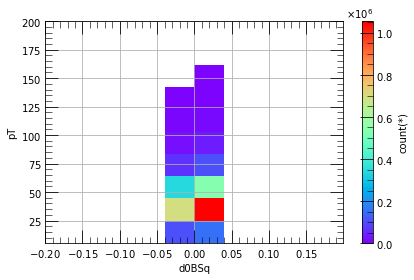

In [235]:
new_cmp = change_cmap_bkg_to_white("rainbow")

selec = abs(vdf_concat.eta) < 0.2 
x_lim = [min(equal_entry_bin_edges_qd0), max(equal_entry_bin_edges_qd0)]
y_lim = [min(equal_entry_bin_edges_pT), max(equal_entry_bin_edges_pT)]
# d0BSq_lim = 
vdf_concat.plot(vdf_concat.d0BSq, vdf_concat.pT, 
                limits=[x_lim, y_lim], 
                colormap=new_cmp,
                selection=[selec],
               shape=(10,10) )
                #, grid=)

# plt.savefig("/Users/Jake/Desktop/pT_vs_d0__test1.pdf", dpi=500)

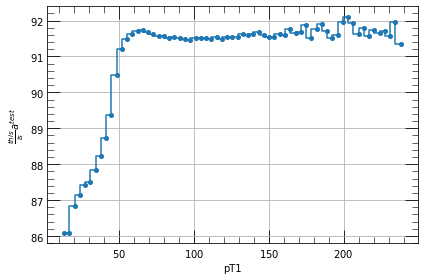

In [24]:
vdf.plot1d(vdf.pT1, what='mean(massZ)', ylabel=r"$\frac{this}{is} a^{test}$")

/Users/Jake/anaconda3/lib/python3.7/site-packages/vaex/image.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rgba_dest[:, :, c][[mask]] = np.clip(result[[mask]], 0, 1)


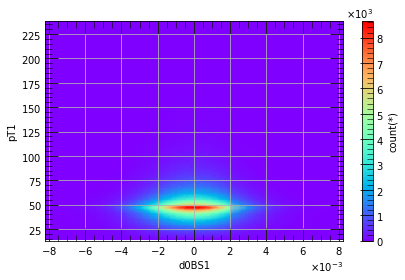

In [36]:
vdf.plot(vdf.d0BS1, vdf.pT1, colormap='rainbow', selection=[None, vdf.d0BS1 < .002, None], background_color='black',)
plt.savefig("/Users/Jake/Desktop/test1.png")

# Split stuff below into their own scripts. 

In [ ]:
%%time

kbin_test = KinematicBin(df_MC_2016, 
                    n_evts=15541434, 
                    massZ_cut_ls=[60,120],
                    eta_cut_ls=[0.0, 2.5], 
                    pT_cut_ls=[0, 1000], 
                    d0q_cut_ls=[-10, 10],
                    d0_type='BS',
                    dR_cut=0.008,
                    use_ptotal_instead=False, 
                    verbose=True)

In [ ]:
# Drop the extraneous columns in Filippo's samples. 

mystr = "massZ_vtx,massZ_vtx_FSR,massErrZ_vtx,massErrZ_vtx_FSR,massZ_vtxChi2,massZ_vtx_BS,massZ_vtx_BS_FSR,massErrZ_vtx_BS,massErrZ_vtx_BS_FSR,massZ_vtxChi2_BS,vtx_pT1,vtx_pT2,vtx_eta1,vtx_eta2,vtx_phi1,vtx_phi2,vtx_BS_pT1,vtx_BS_pT2,vtx_BS_eta1,vtx_BS_eta2,vtx_BS_phi1,vtx_BS_phi2,vtx_pT_FSR1,vtx_pT_FSR2,vtx_eta_FSR1,vtx_eta_FSR2,vtx_phi_FSR1,vtx_phi_FSR2,vtx_BS_pT_FSR1,vtx_BS_pT_FSR2,vtx_BS_eta_FSR1,vtx_BS_eta_FSR2,vtx_BS_phi_FSR1,vtx_BS_phi_FSR2"
drop_ls = mystr.split(",")

for ser in drop_ls:
    try:
        df_vaex_fromhdf5.drop(ser, inplace=True)
    except KeyError:
        continue

In [ ]:
get_there = 99
regions = 342
while get_there > 8:
    regions += 1
    print("Running over {} regions".format(regions))
    bin_reg_ls = find_equal_hist_regions_unbinned(all_pT_arr_upto200GeV, regions, verbose=False)
    get_there = bin_reg_ls[1]

In [ ]:
all_eta_arr = kbin_test.apply_mask_get_data("eta1", lep_selection_type="independent", weave=True)
# all_eta_arr2 = kbin2.apply_mask_get_data("eta1", lep_selection_type="independent", weave=True)

# all_pT_arr = kbin_test.apply_mask_get_data("pT1", lep_selection_type="independent", weave=True)
# all_qd0BS_arr = kbin_test.apply_mask_get_data("d0BSq1", lep_selection_type="independent", weave=True)

# all_pT_arr_upto200GeV = all_pT_arr[all_pT_arr <= 200]

In [ ]:
%%time
# bin_reg_ls_eta = find_equal_hist_regions_unbinned(all_eta_arr, 22, verbose=True)
# bin_reg_ls_eta2 = find_equal_hist_regions_unbinned(all_eta_arr2, 20, verbose=True)
# bin_reg_ls_pT = find_equal_hist_regions_unbinned(all_pT_arr, 10, verbose=False)
# bin_reg_ls_pT_upto200GeV = find_equal_hist_regions_unbinned(all_pT_arr_upto200GeV, 10, verbose=True, round_to_n_decimals=2)
# bin_reg_ls_qd0 = find_equal_hist_regions_unbinned(all_qd0BS_arr, 10, verbose=True, round_to_n_decimals=5)


print(collapse_eta_bin_edges(bin_reg_ls_eta))

In [ ]:
%%time
kbin_test.plot_1D_kinematics(kinem="eta1", lep_selection_type="independent", x_limits=[-2.5, 2.5], bin_limits=[-2.4,2.4,0.1], run_over_only_n_evts=-1, ax=None, x_label="", y_label="", title="", y_max=-1, log_scale=False, iter_gaus=(False, 0))

# Make $p_T$ distributions in different $\eta$ bins.

In [ ]:
%%time
%config InlineBackend.figure_format = 'retina'
# f, ax = plt.subplots(figsize=(12.8,9.6))

n_evts_scan = 2000000
# n_evts_scan = 300000
n_evts_keep = 1000000

df = df_MC_2016
d0_bin_limits = [-1, 1, 2]
massZ_cut_ls=[60,120]
pT_cut_ls=[5,1000]
eta_cut_ls=[
    [0.0, 0.2],
    [0.2, 0.4],
    [0.4, 0.6],
    [0.6, 0.8],
    [0.8, 1.0],
    [1.0, 1.2],
    [1.2, 1.4],
    [1.4, 1.6],
    [1.6, 1.8],
    [1.8, 1.9],
    [1.9, 2.0],
    [2.0, 2.1],
    [2.1, 2.2],
    [2.2, 2.3],
    [2.3, 2.4],
]

d0_type='BS'
dR_cut=0.008
use_ptotal_instead=False
fit_iters = 3

# outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/pT_distributions_eta_binning/DY_MC_2016_3Mevts.pdf"
outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/pT_distributions_eta_binning/test_09.pdf"
overwrite = True
verbose = True

#--- Automatons ---#
dir_ = os.path.dirname(outpath)
check_overwrite(outpath, overwrite)
makeDirs(dir_) 

org_kbin_ls = []
with PdfPages(outpath) as pdf:
    for eta_reg_ls in eta_cut_ls: 
        org_kbin = KinBinOrganizer(df, n_evts_scan, massZ_cut_ls, eta_reg_ls, pT_cut_ls, d0_type, dR_cut, use_ptotal_instead, verbose)
        org_kbin.make_kbin_ls_over_d0_range(d0_bin_limits)
        org_kbin.plot_dpToverpT_for_kbin_ls(kinem="pT1", lep_selection_type='independent', 
                                           x_limits=[-40, 250], bin_limits=[5, 200, 1], 
                                           run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, 
                                           iter_gaus=(False, fit_iters),
                                           make_pdf=True,
                                           pdf_obj=pdf    # If make_pdf=True, must pass in pdf object here!
                                           )  
#         org_kbin.get_iter_gaus_fit_stats("pT1")

        org_kbin_ls.append(org_kbin)
        plt.close("all")
    # Done looping over all eta regions.
    
    # Plot all graph lines on single axes. 
#     graph_ls = []
#     f, ax = plt.subplots()
#     for count,org_kb in enumerate(org_kbin_ls, 1):
#         graph = GraphLine(org_kb.d0_bin_arr_shifted, org_kb.fit_mean_ls, org_kb.fit_mean_err_ls)
#         graph.draw_graph("d0BSq1", "delta_pToverpT1", binning_type=binning_type, kbin_example=org_kb.kbin_ls[0], ax=ax, count=count)
#         # Note: if you want stats to show up on plot when doing draw_graph, then make sure count=1 at some point.
#         graph_ls.append(graph)
#     # Done looping over KinBinOrganizers.
#     plt.tight_layout()
#     pdf.savefig()
#     plt.close("all")

In [ ]:
outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/find_best_binning__eta_pT_qd0/test6.pdf"
verbose = False

n_events_scan = 50000

n_divisions_start = 1
n_divisions_end = 16

d0q_cut_ls = [-1, 1]
massZ_cut_ls=[60,120]
pT_cut_ls=[5,1000]
eta_cut_ls=[1.0, 1.2]

d0_type='BS'
dR_cut=0.008
use_ptotal_instead = False
verbose = False
overwrite = True

bin_limits = [0,200,1]
x_limits=[-5,220]

#--------------------------------#
#---------- Automatons ----------#
#--------------------------------#
plt.style.use("cmsstyle_plot")

df = pd.read_hdf(dataframe)

dir_ = os.path.dirname(outpath)
check_overwrite(outpath,overwrite)
makeDirs(dir_) 

kb = KinematicBin(df_original=df,
                  n_evts=n_events_scan,
                  massZ_cut_ls=massZ_cut_ls,
                  eta_cut_ls=eta_cut_ls, 
                  pT_cut_ls=pT_cut_ls, 
                  d0q_cut_ls=d0q_cut_ls,
                  d0_type=d0_type,
                  dR_cut=dR_cut,
                  use_ptotal_instead=use_ptotal_instead, 
                  verbose=verbose)

with PdfPages(outpath) as pdf:

    # Must make distribution to divide it up into regions.
    kb.plot_1D_kinematics(kinem="pT1", lep_selection_type="independent", 
                          x_limits=x_limits, bin_limits=bin_limits, 
                          run_over_only_n_evts=-1, 
                          ax=None, x_label="", y_label="", title="", y_max=-1, log_scale=False, 
                          iter_gaus=(False, 0))
    pdf.savefig()
    plt.close("all")
    
    bin_vals = kb.stats_dict['pT1']['bin_vals']
    bin_edges = kb.stats_dict['pT1']['bin_edges']

    f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(9.6,9.6))
    eta_cuts = kb.cut_dict['eta']

    division_ls = list(range(n_divisions_start, n_divisions_end+1))
    mean_perc_diff_ls = []

    for divisions in division_ls:
        pT_bins, this_dict = find_equal_hist_divisions(bin_edges, bin_vals, divisions, verbose=verbose)

        abs_perc_diff_ls = [abs(perc) for perc in this_dict.values()] 
        mean_perc_diff = np.mean(abs_perc_diff_ls)
        mean_perc_diff_ls.append(mean_perc_diff)

        x_vals = np.ones(len(pT_bins)) * divisions
        abs_perc_diff_ls.insert(0,0)

        ax1.errorbar(x=x_vals, y=pT_bins, yerr=abs_perc_diff_ls, linestyle="", markersize=2)

    ax2.plot(division_ls, mean_perc_diff_ls)

    ax1.set_title(r"%s" % eta_cuts)
    ax1.set_ylabel(r"$p_T$ bins [GeV]")
    ax2.set_xlabel(r"Equal-entry divisions in $p_T$ distribution")
    ax2.set_ylabel(r"mean(abs(% diff.)")

    pdf.savefig()
    plt.close("all")
    


# Suzanne's 2D plotter.

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.backends.backend_pdf

class Histogram():

    def __init__(self, filesave, xdata, title, ydata=None, zdata=None, isDataFrame=False, label=False, labelsize=7, comap=None, vmin=None, vmax=None, fmt=None, whiteBkgd=False):
        """
        This class takes in up to three distinct datasets. 
        If the dataset is input as a Pandas DataFrame, it only requires one input, which we take to be xdata. 
        The data will be handled differently depending on whether or not it is a dataframe, 
        so the isDataFrame boolean will be used to dictate how to handle the data. 
        The label input becomes the Seaborn annot input, which may be True, False, or a set of user-defined labels. 
        
        How to use a DataFrame:
            rows : x_data
            cols : 
        """

        self.filesave = filesave # Save the file using this name
        self.xdata = xdata 
        self.df_bool = isDataFrame # Is xdata a Pandas DataFrame?
        self.colmap = comap # Desired colormap
        self.label = label # Annotation label. (Set to True for numbers, False for empty, or customize with a user-generated label)
        self.labelsize = labelsize # Font size of label
        self.vmin = vmin # Colorbar min
        self.vmax = vmax # Colorbar max
        self.fmt = fmt # Format of label (Default is '.2g')
        # self.whitebkfg_bool = whiteBkgd
        self.title = title

        self.MakeHeatmap()

    def MakeHeatmap(self):
        # if self.whitebkfg_bool:
        #     print("[HISTOGRAM] Changing background to white.")
        #     self.colormap = self.ChangeBkgdToWhite()

        if self.df_bool:
            # If the data is a Pandas DataFrame, use this block to make a heatmap.
            plt.clf()
            self.hm = sb.heatmap(self.xdata, cmap=self.colmap, annot=self.label, annot_kws={"size": self.labelsize}, vmin=self.vmin, vmax=self.vmax, fmt=self.fmt)
            self.hm.invert_yaxis()
            # plt.show()
            self.hm.set_title(self.title, fontdict={'fontsize':16})
            # hm.figure.savefig(self.filesave)
            # print("[HISTOGRAM] File saved as {}".format(self.filesave))
        return self.hm

    def saveHist(self,filesave):
        self.hm.figure.savefig(filesave)

    # def ChangeBkgdToWhite(self, n=256):
    #     print('[HISTOGRAM] ChangeBkgdToWhite has been called.')
    #     tmp_colors = cm.get_cmap(self.colormap, n)
    #     newcolors = tmp_colors(np.linspace(0, 1, n))
    #     white = np.array([1, 1, 1, 1])    # White background (Red, Green, Blue, Alpha).
    #     newcolors[0, :] = white    # Only change bins with 0 entries.
    #     newcmp = ListedColormap(newcolors)
    #     return newcmp

# Grids of 2D plots.

#### FIXME: 
- [ ] Use np.arrays to contain kbins for easy reshaping?
- [ ] Eventually merge into make_grid_of_2D_plots_FIXME.py

In [ ]:
%%time

n_evts = 10000

eta_bin_BARREL  = [0.0, 0.3]
eta_bin_OVERLAP = [0.8, 1.1]
eta_bin_ENDCAP  = [2.1, 2.4]


pT_bin_LOW1 = [5, 7]
pT_bin_LOW2 = [7, 10]
pT_bin_LOW3 = [10, 15]
pT_bin_LOW4 = [15, 20]
pT_bin_LOW5 = [20, 25]
pT_bin_LOW6 = [25, 30]

pT_bin_MED1 = [30, 35]
pT_bin_MED2 = [35, 40]
pT_bin_MED3 = [40, 45]
pT_bin_MED4 = [45, 50]
pT_bin_MED5 = [50, 55]
pT_bin_MED6 = [55, 60]

pT_bin_HIGH1 = [60, 65]
pT_bin_HIGH2 = [65, 70]
pT_bin_HIGH3 = [70, 75]
pT_bin_HIGH4 = [75, 80]
pT_bin_HIGH5 = [80, 90]
pT_bin_HIGH6 = [90, 100]

#--------------#
#--- Barrel ---#
#--------------#
# Low pT.
kbin_eta_BARREL_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# Med pT.
kbin_eta_BARREL_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_BARREL_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)


# #---------------#
# #--- Overlap ---#
# #---------------#
# # Low pT.
# kbin_eta_OVERLAP_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# # Med pT.
# kbin_eta_OVERLAP_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_OVERLAP_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)

# #---------------#
# #--- Endcap ---#
# #---------------#
# # Low pT.
# kbin_eta_ENDCAP_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# # Med pT.
# kbin_eta_ENDCAP_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_ENDCAP_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)

In [ ]:
import matplotlib.pyplot as plt
from d0_Utils.d0_fns import calc_x_err_bins
from d0_Utils.d0_dicts import color_dict, label_LaTeX_dict

class GraphLine():
    """
    One of the lines drawn on a graph. Contains all the info that went into building this line. 
    """
    def __init__(self, x_vals, y_vals, y_err_vals=np.zeros(0)):
        self.x_vals = x_vals
        self.y_vals = y_vals
#         self.x_err_vals = x_err_vals
        self.y_err_vals = y_err_vals
        
    def draw_graph(self, kinem_x, kinem_y, x_label="", y_label="", binning_type="", kbin_example=None, ax=None):
        """
        kinem_x : str
            The full name of the kinematic variable plotted on the x-axis.
            Should be a key in the label_LaTeX_dict.
        kinem_y : str
            The full name of the kinematic variable plotted on the y-axis.
            Should be a key in the label_LaTeX_dict.
        """
        if binning_type not in ["eta", "pT"]:
            raise ValueError("[ERROR] Wrong `binning_type` specified. Must be either 'pT' or 'eta'. Stopping now.")
            
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8, 9.6))
            
#         #--- Check that things make sense: ---#
#         # Example: If binning in eta, make sure each HistInfo object has identical pT_cuts as every other.
#         wrong_eta_binning = (binning_type in 'eta') and len(set([(hist.pT_range[0], hist.pT_range[1]) for hist in entire_HistInfo_list])) != 1
#         # Do same thing for binning in pT.
#         wrong_pT_binning = (binning_type in 'pT') and len(set([(hist.eta_range[0], hist.eta_range[1]) for hist in entire_HistInfo_list])) != 1
#         if (wrong_eta_binning or wrong_pT_binning):
#             err_msg = f"\n\nBinning type ({binning_type}) specified, "
#             err_msg += f"but not all graphs share same {binning_type}_range. Stopping now."
#             raise RuntimeError(err_msg)
        al=1  # alpha=0 is transparent
        elw=1  # error bar line width
        ecolor='k'
        ms=4  # marker size
        mec='k'  # marker edge color
        cs=1  # cap size
        mew=0.7  # marker edge width

        if len(x_label) == 0:
            x_label = label_LaTeX_dict[kinem_x]["independent_label"]
        if len(y_label) == 0:
            y_label  = label_LaTeX_dict[kinem_y]["independent_label"]
            y_label += " (iterated Gaus fit mean)"
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        # The "x-errors" are calculated automatically to be 1/2 the distance to the next data point. 
        low_x_err, high_x_err = calc_x_err_bins(self.x_vals)
        
        label_text = kbin_example.cut_dict[binning_type]
        ax.errorbar(self.x_vals, self.y_vals, xerr=[low_x_err, high_x_err], yerr=self.y_err_vals, fmt='.', label=label_text,
                #color=color_dict[count], 
                    elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
        ax.legend(loc="lower right", framealpha=al)#, fontsize=text_size_legend)
        
        # Don't show d0 cuts and the cuts of whatever binning type (like "eta") is being used.
        tmp_dict = kbin_example.cut_dict.copy()
        for key in list(kbin_example.cut_dict.keys()):
            if (binning_type in key) or ("d0" in key):
                del tmp_dict[key]
                    
        sorted_cut_ls = [value for (key, value) in sorted(tmp_dict.items())]
        cut_str = combine_cut_list(sorted_cut_ls)
        textbox_text = cut_str  # Don't show the d0 cut text. Luckily it is the first by alphabetical sorting. 
        ax.text(0.025, 0.87, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
    def do_linear_fit(self, ax=None):
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8,9.6)) 
        
        # Do fit. 
        # Draw fit on axes.
        # return optimized parameters
        self.popt_linear = None

In [ ]:
n_evts = 1000

# dataframe = pd.read_hdf('/Users/Jake/Desktop/MC_2016.h5')


massZ_cut_ls = [60,120]
d0q_cut_ls = [-0.01, 0.01]
d0_type = "BS"
dR_cut = 0.02
use_ptotal_instead = False
verbose = False

eta_regions = [
    [0.0, 0.3],
    [0.8, 1.1],
#     [2.1, 2.4]
]

# You should make there's always 18 different regions.
pT_regions = [
    [5, 7]  ,
    [7, 10] ,
    [10, 15],
    [15, 20],
    [20, 25],
#     [25, 30],
#     [30, 35],
#     [35, 40],
#     [40, 45],
#     [45, 50],
#     [50, 55],
#     [55, 60],
#     [60, 65],
#     [65, 70],
#     [70, 75],
#     [75, 80],
#     [80, 90],
#     [90, 100]
]

all_kbin_ls = []
for eta_reg in eta_regions:
    for pT_reg in pT_regions:
        all_kbin_ls.append( KinematicBin(df_MC_2016, n_evts, massZ_cut_ls, eta_reg, pT_reg, d0q_cut_ls, 
                                         d0_type, dR_cut, use_ptotal_instead, verbose) 
                          )

In [ ]:
kb1 = all_kbin_ls[0]
kb2 = all_kbin_ls[1]
kb3 = all_kbin_ls[2]

# First edition $dp_T/p_T^2$ vs. $d_0*q$ plotter

In [ ]:
def make_graph(*graph_tuple, binning_type='eta', verbose=False, save_plots=True, outpath='/Users/Jake/Desktop/'):
    """
    Make one deltapT vs. d0*charge plot, with as many graphs displayed as len(graph_tuple).
    graph_tuple contains many lists (graph_lsX) of histograms (HistInfo).
    
    graph_tuple = (
        graph_ls1,  # Each hist in this graph_ls all have identical cuts, but are made over different d0 bins.
        graph_ls2,  # This graph_ls2 may have slightly different cuts than graph_ls1.
        ...,
    )
    
    #--- Example ---#
    graph_ls1 = [HistInfo1, HistInfo2, ...]  # This list will generate 1 deltapT_vs_d0charge graph. 
    graph_ls2 = [HistInfo1, HistInfo2, ...]  # This list will generate another graph, but may have different cuts. 

    If binning_type is 'eta', then each graph_ls in graph_tuple should have the same pT cuts.
        This way, we can view different eta ranges while making sure pT cuts are all the same. 
    If binning_type is 'pT', then each graph_ls in graph_tuple should have the same eta cuts. 
    
    Returns
    -------
    graph_ls contains all the correct graph info to make a plot. 
    """    

        
    text_size_legend = 6
    text_size_ax_labels = 12
    text_size_tick_labels = 8
    text_size_title = 12


    # If binning in eta, then each graph should the same pT cuts. 
    if binning_type in 'eta':
        title_str += f'{example_graph.pT_range[0]}<' + r'$p_T$' + f'<{example_graph.pT_range[1]} GeV'
    elif binning_type in 'pT':
        title_str += f'{example_graph.eta_range[0]}<' + r'$\left| \eta \right|$' + f'<{example_graph.eta_range[1]}'
    ax.set_title(title_str)

    x_min = min([gr.d0_bin_window[0] for gr in example_graph_ls])
    x_max = max([gr.d0_bin_window[1] for gr in example_graph_ls])
    bin_edge_left = example_graph.d0_bin_window[0]
    bin_edge_right = example_graph.d0_bin_window[1]
    x_bin_width = abs(bin_edge_right - bin_edge_left)

    # ax.set_xlim([x_min*x_axis_scale, x_max*x_axis_scale])
    ax.set_xlim([-0.012, 0.012])
    ax.set_ylim([-0.005, 0.005])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
    
    # Gridlines.
    ax.grid(which='major',color='k', ls=':')

    x_bin_arr = np.arange(x_min, x_max+0.5*x_bin_width, x_bin_width)  # Includes all bin edges: very first to very last.
    x_n_bins = calc_num_bins(x_min, x_max, x_bin_width)

    # Calculate %diff for ratio plot.
    # acc_ZD_arr = np.array(acc_ZD, dtype=float)
    # acc_ALP_arr = np.array(acc_ALP, dtype=float)
    # acc_perc_diff_arr = (acc_ALP_arr - acc_ZD_arr) / acc_ZD_arr

    # Calculate errors on %diff.
    # acc_perc_diff_err_arr = getUncertOfFractionBinomial(acc_ALP_arr, acc_ZD_arr)

    # Plot the data.
    for count, gr_ls in enumerate(graph_tuple, 1):
        example_gr = gr_ls[0]
        y_vals = [gr.hist_mean for gr in gr_ls]
        y_vals_err = [gr.hist_mean_err for gr in gr_ls]
        if (verbose): 
            print(f'y_vals for graph_ls {count}:\n{y_vals}\n')

            
            
    
        plotname  = (f'deltapT_vs_d0{example_graph.bspv}timescharge_{example_graph.sample}{example_graph.year}_'
                     f'{binning_type}binning__')
        if binning_type in 'pT':
            plotname += f'{example_graph.eta_range[0]}_eta_{example_graph.eta_range[1]}'
        elif binning_type in 'eta':
            plotname += f'{example_graph.pT_range[0]}_pT_{example_graph.pT_range[1]}'
        plotname = make_str_title_friendly(plotname)
        
        fullpath = os.path.join(outpath, plotname)
        if not os.path.exists(outpath):
            os.makedirs(outpath)
        plt.savefig(fullpath + '.pdf')
        plt.savefig(fullpath + '.png')
        print("Plot saved at:\n", fullpath)
    

# def make_kinem_comparison_plot(df, year, sample, 
# 
#     
#     pdf_name  = f"{year}_{sample}_"
#     title_str_pT_min = f"0{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
#     # Example of Python magic: auto-concatenation of strings.
#     pdf_name += (f"{kinem_gen}_vs_{kinem_rec}__{bspv}"
#                  f"__{title_str_pT_min}_pT_{pT_max}"
#                  f"__{eta_min_abs}_abs_eta_{eta_max_abs}"
#                  f"__{d0_min:.3f}_to_{d0_max:.3f}_increm_{d0_bin_width:.3f}")
#                 #  f"__wrt_{wrt}")
#     pdf_name = make_str_title_friendly(pdf_name) + ".pdf"
#     
#     outfile = os.path.join(outfile_path, pdf_name)
#     if not os.path.exists(outfile_path):
#         os.makedirs(outfile_path)
#     if os.path.exists(outfile) and not (overwrite):
#         print(f"Skipping {outfile} since it already exists.\nTo write over the file then set overwrite=True.\n")
#         return
#         
#     status = f"Running over: {year} {sample} {bspv}, pT_range={pT_cut_ls}, eta_range={eta_cut_ls}, wrt {wrt}"
#     print(status)
# 
# 
#         for k in range(len(d0_bin_arr)-1):
#             this_d0_bin = d0_bin_arr[k]
#             next_d0_bin = d0_bin_arr[k+1]
#             if bspv in 'BS':
#                 mask_d0BSxcharge = (this_d0_bin < d0BSxcharge_ser) & (d0BSxcharge_ser < next_d0_bin)
#                 # mask_d0BS2xcharge = (this_d0_bin < d0BS2xcharge_ser) & (d0BS2xcharge_ser < next_d0_bin)
#             elif bspv in 'PV':
#                 mask_d0PVxcharge = (this_d0_bin < d0PVxcharge_ser) & (d0PVxcharge_ser < next_d0_bin)
#                 # mask_d0PV2xcharge = (this_d0_bin < d0PV2xcharge_ser) & (d0PV2xcharge_ser < next_d0_bin)
# 
#                 
#  
#             # Store info of this plot in HistInfo objects. 
#             hist_gen = HistInfo()
#             hist_rec = HistInfo()            
#             hist_gen.year = year
#             hist_rec.year = year
#             hist_gen.sample = sample 
#             hist_rec.sample = sample
#             hist_gen.bspv = bspv 
#             hist_rec.bspv = bspv
#             hist_gen.d0_bin_window = [this_d0_bin, next_d0_bin] 
#             hist_rec.d0_bin_window = [this_d0_bin, next_d0_bin]
#             hist_gen.x_axis_bounds_list = x_range_ls[0:2] # 2-element list 
#             hist_rec.x_axis_bounds_list = x_range_ls[0:2] # 2-element list
#             hist_gen.eta_range = eta_cut_ls 
#             hist_rec.eta_range = eta_cut_ls
#             hist_gen.pT_range = pT_cut_ls
#             hist_rec.pT_range = pT_cut_ls
#             hist_gen.massZ_cut = massZ_min
#             hist_rec.massZ_cut = massZ_min
#             hist_gen.n_entries = n_entries_gen
#             hist_rec.n_entries = n_entries_rec
#             hist_gen.hist_mean = mean_gen
#             hist_rec.hist_mean = mean_rec
#             hist_gen.hist_mean_err = mean_err_gen
#             hist_rec.hist_mean_err = mean_err_rec
#             hist_gen.hist_stdev = stdev_gen
#             hist_rec.hist_stdev = stdev_rec  # Spread of the data.
#             hist_gen.hist_stdev_err = stdev_err_gen
#             hist_rec.hist_stdev_err = stdev_err_rec
#             
#             graph_info_gen_ls.append(hist_gen)
#             graph_info_rec_ls.append(hist_rec)
 

In [ ]:
%config InlineBackend.figure_format ='retina'

fig = plt.figure(figsize=(25.6,19.2))
ax = plt.subplot(221)
kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.5, 0.5], bin_limits=[-0.5, 0.5, 0.004], run_over_only_n_evts=-1, ax=ax, y_max=-1, log_scale=False, iter_gaus=(True, 3))
ax = plt.subplot(222)
kbin.plot_1D_kinematics(kinem="delta_pToverRecpT1", lep_selection_type='independent', x_limits=[-0.5, 0.5], bin_limits=[-0.5, 0.5, 0.004], run_over_only_n_evts=-1, ax=ax, y_max=-1, log_scale=False, iter_gaus=(False, 3))
ax = plt.subplot(223)
kbin.plot_1D_kinematics(kinem="d0BSq1", lep_selection_type='independent', x_limits=[-0.05, 0.05], bin_limits=[-0.02, 0.02, 0.0004], run_over_only_n_evts=n_evts_keep, ax=ax, y_max=-1, log_scale=False, iter_gaus=(True, 4))
ax = plt.subplot(224)
kbin.plot_1D_kinematics(kinem="d0BSq2", lep_selection_type='independent', x_limits=[-0.05, 0.05], bin_limits=[-0.02, 0.02, 0.0004], run_over_only_n_evts=n_evts_keep, ax=ax, y_max=-1, log_scale=False, iter_gaus=(False, 3))

# Kinematics subplots.

In [ ]:
# kbin.plot_1D_kinematics(kinem="d0BSq1", lep_selection_type='independent', x_limits=[-0.02, 0.02], bin_limits=[-0.008, 0.008, 0.0002], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))
kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))

In [ ]:
# hist_mean = kbin.stats_dict['delta_pToverpT1']['hist_stats'][1]
# hist_mean_err = kbin.stats_dict['delta_pToverpT1']['hist_stats'][2]
# fit_mean = kbin.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1]
# fit_mean_err = kbin.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1]

d0_bin_arr, d0_bin_width = make_binning_array(d0_bin_limits)
d0_bin_arr_shifted = shift_binning_array(d0_bin_arr)

if d0_bin_width < 0.0005:
    err_msg = f"WARNING: d0_bin_width ({d0_bin_width}) is too small (d0_bin_width < 0.0005).\nStopping now."
    raise ValueError(err_msg)    

# Make list of kinematic bins.
kbin_ls = []
with PdfPages(outpath) as pdf:
    for elem in range(len(d0_bin_arr)-1):
        # Make a kbin for each d0 bin.
        d0_this = d0_bin_arr[elem]
        d0_next = d0_bin_arr[elem+1]

        kbin = KinematicBin(df_MC_2016, 
                            n_evts=n_evts_scan, 
                            massZ_cut_ls=[60,120],
                            eta_cut_ls=[0.0, 0.3], 
                            pT_cut_ls=[40, 50], 
                            d0q_cut_ls=[d0_this, d0_next],
                            d0_type='BS',
                            dR_cut=0.02,
                            use_ptotal_instead=False, 
                            verbose=True)
        kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))
        kbin_ls.append(kbin)
        
        pdf.savefig()
        plt.close()

# Get graph values.
hist_mean_ls     = []
hist_mean_err_ls = []
fit_mean_ls      = []
fit_mean_err_ls  = []
for kb in kbin_ls:
    hist_mean_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][1])
    hist_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][2])
    fit_mean_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1])
    fit_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1])

al=1  # alpha=0 is transparent
elw=1  # error bar line width
ecolor='k'
ms=4  # marker size
mec='k'  # marker edge color
cs=1  # cap size
mew=0.7  # marker edge width

low_x_err, high_x_err = calc_x_err_bins(d0_bin_arr_shifted)
    
fig, ax = plt.subplots(figsize=(12.8,9.6))

# legend_text = ""
# ax.text(k, y, "Some words", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#             legend_text = f'{example_gr.pT_range[0]} <' + r' $p_T$ ' + f'< {example_gr.pT_range[1]}'
ax.errorbar(d0_bin_arr_shifted, fit_mean_ls, xerr=[low_x_err, high_x_err], 
            yerr=fit_mean_err_ls, fmt='s', label="some cuts go here?",
        #color=color_dict[count], 
            elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
ax.legend(loc='upper left', framealpha=al)#, fontsize=text_size_legend)